In [3]:
import numpy as np
from collections import deque
import nltk
import re
from nltk.corpus import brown
from nltk.corpus import gutenberg
nltk.download('gutenberg')
nltk.download('stopwords')
nltk.download('brown')
nltk.download('punkt')


class InputData:
    def __init__(self, sentences):
        self.sentences = sentences
        self.normalize()
        self.counter = 0
        self.wordId_frequency_dict = dict()
        self.word_count = 0  #  Number of words (repeated words only count as 1)
        self.word_count_sum = 0  # Total number of words (the number of repeated words also accumulates)
        self.sentence_count = 0  # Number of sentences
        self.id2word_dict = dict()
        self.word2id_dict = dict()
        self._init_dict()  # Initialize the dictionary
        self.sample_table = []
        self._init_sample_table()
        self.word_pairs_queue = deque()

        print('Word Count is:', self.word_count)
        print('Word Count Sum is', self.word_count_sum)
        print('Sentence Count is:', self.sentence_count)

    def normalize(self):
      stop_words = nltk.corpus.stopwords.words('english')
      norm_sentences_word_list = []
      for word_list in self.sentences:
        sentence = " ".join(word for word in word_list)
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        sentence = sentence.lower()
        sentence = re.sub(' +', ' ', sentence)
        sentence = sentence.strip()
        norm_word_list = sentence.split(' ')
        norm_word_list = [word for word in norm_word_list if word not in stop_words]
        if(len(norm_word_list) > 1):
          norm_sentences_word_list.append(norm_word_list)
       
      self.sentences = norm_sentences_word_list

    def _init_dict(self):
        word_freq = dict()
        for word_list in self.sentences:
            self.word_count_sum += len(word_list)
            self.sentence_count += 1
            for word in word_list:
                try:
                    word_freq[word] += 1
                except:
                    word_freq[word] = 1
        word_id = 0
        # Initialize word2id_dict, id2word_dict, wordId_frequency_dict dictionary
        for per_word, per_count in word_freq.items():
            self.id2word_dict[word_id] = per_word
            self.word2id_dict[per_word] = word_id
            self.wordId_frequency_dict[word_id] = per_count
            word_id += 1
        self.word_count = len(self.word2id_dict)

    def _init_sample_table(self):
        sample_table_size = 1e8
        frequency = np.array(list(self.wordId_frequency_dict.values())) ** 0.75
        frequency_sum = sum(frequency)
        ratio_array = frequency / frequency_sum 
        word_count_list = np.round(ratio_array * sample_table_size)
        for word_index, word_freq in enumerate(word_count_list):
            self.sample_table += [word_index] * int(word_freq)  # it generates a list, the content is the id of each word, each id in the list is repeated multiple times, the number of repetitions is the word frequency
        self.sample_table = np.array(self.sample_table)
        print(self.sample_table.shape)

    def generate_positive_pairs(self, window_size, neg_count):
        self.counter += 1
        if not self.sentences[20*(self.counter-1):20*self.counter]:
            self.counter = 1
            self.word_pairs_queue.clear()
        sub_wids = [[self.word2id_dict[word] for word in word_list] for word_list in self.sentences[20*(self.counter-1):20*self.counter]]

        
        for words in sub_wids:
          sentence_length = len(words)
          for index, center_word in enumerate(words):
            start = index - window_size
            end = index + window_size + 1

            positive_words = []
            for index_2 in range(start,end):
              if 0 <= index_2 < sentence_length and index_2 != index:
                positive_words.append(words[index_2])
              elif index_2 < 0 or index_2 >= sentence_length:
                positive_words.append(self.word_count)
            
            negative_words = np.random.choice(self.sample_table, size=neg_count).tolist()

            self.word_pairs_queue.append((center_word, positive_words, negative_words))
           


    def get_batch_pairs(self, batch_size, window_size, neg_count):

        while len(self.word_pairs_queue) < batch_size:
          self.generate_positive_pairs(window_size, neg_count)              
              
        result_pairs = []
        for _ in range(batch_size):
            result_pairs.append(self.word_pairs_queue.popleft())
        return result_pairs


    def evaluate_pairs_count(self):
        return self.word_count_sum


def test():
    sentences = brown.sents(categories=['news'])[:2]
    test_data = InputData(sentences)
    print(" ".join(word for word in sentences[0]))
    print(" ".join(word for word in sentences[1]))
    pos_pairs = test_data.get_batch_pairs(10, 2, 8)
    print('positive:')
    print(pos_pairs)
    pos_word_pairs = []
    for pair in pos_pairs:
        pos_word_pairs.append((test_data.id2word_dict[pair[0]], [test_data.id2word_dict[i] for i in pair[1] if i != test_data.word_count], [test_data.id2word_dict[i] for i in pair[2] if i != test_data.word_count]))
    print(pos_word_pairs)
    print(len(pos_pairs))

    pos_pairs = test_data.get_batch_pairs(10, 2, 8)
    print('positive:')
    print(pos_pairs)
    pos_word_pairs = []
    for pair in pos_pairs:
        pos_word_pairs.append((test_data.id2word_dict[pair[0]], [test_data.id2word_dict[i] for i in pair[1] if i != test_data.word_count], [test_data.id2word_dict[i] for i in pair[2] if i != test_data.word_count]))
    print(pos_word_pairs)
    print(len(pos_pairs))


if __name__ == '__main__':
    test()

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
(100000004,)
Word Count is: 29
Word Count Sum is 34
Sentence Count is: 2
The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .
The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
positive:
[(0, [29, 29, 1, 2], [6, 23, 2, 2, 6, 14, 3, 28]), (1, [29

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import euclidean_distances


class SkipGramModel(nn.Module):
    def __init__(self, emb_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.w_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(emb_size + 1, emb_dimension, sparse=True)
        self._init_emb()

    def _init_emb(self):
        initrange = 0.5 / self.emb_dimension
        self.w_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, pos_w, pos_v, neg_v):
        emb_w = self.w_embeddings(torch.LongTensor(pos_w))
        emb_v = self.v_embeddings(torch.LongTensor(pos_v))
        neg_emb_v = self.v_embeddings(torch.LongTensor(neg_v))

        score = torch.mul(emb_w.unsqueeze(1), emb_v)
        score = torch.sum(score, dim=2).squeeze()
        score = F.logsigmoid(score)
        score = torch.sum(score, dim=1).squeeze()

        neg_score = torch.mul(emb_w.unsqueeze(1), neg_emb_v)
        neg_score = torch.sum(neg_score, dim=2).squeeze()
        neg_score = F.logsigmoid(-1 * neg_score)
        neg_score = torch.sum(neg_score, dim=1).squeeze()


        final_score = score + neg_score
        loss = -1 * torch.sum(final_score)
        return loss

    def distance_matrix(self, word_count):
        embedding = self.w_embeddings.weight.data.numpy()[:word_count]
        distance_matrix = euclidean_distances(embedding)
        return distance_matrix


def test():
    model = SkipGramModel(100, 10)
    id2word = dict()
    for i in range(100):
        id2word[i] = str(i)
    pos_w = [0, 2]
    pos_v = [[9,10],[10,12]]
    neg_v = [[23, 42, 74, 32], [32, 24, 62, 53]]
    model.forward(pos_w, pos_v, neg_v)


if __name__ == '__main__':
    test()

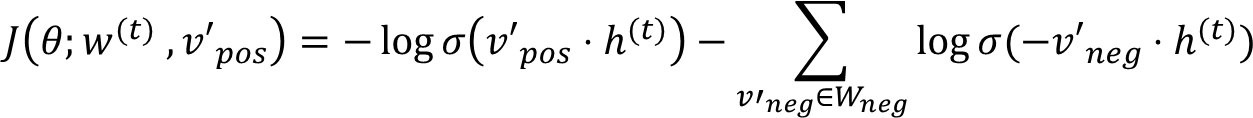

In [28]:
import torch.optim as optim
from tqdm import tqdm

# hyper parameters
WINDOW_SIZE = 2 
BATCH_SIZE = 1000  # mini-batch
EMB_DIMENSION = 100  # embedding dimension
LR = 0.01 # Learning rate
NEG_COUNT = 8


class Word2Vec:
    def __init__(self, sentences):
        self.data = InputData(sentences)
        self.model = SkipGramModel(self.data.word_count, EMB_DIMENSION)
        self.lr = LR
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

    def train(self):
        print("SkipGram Training......")
        pairs_count = self.data.evaluate_pairs_count()
        print("pairs_count", pairs_count)
        batch_count = pairs_count / BATCH_SIZE
        print("batch_count", batch_count)
        for epoch in range(1,51):
            mean_loss = 0
            process_bar = tqdm(range(int(batch_count)))
            for i in process_bar:
                pos_pairs = self.data.get_batch_pairs(BATCH_SIZE, WINDOW_SIZE, NEG_COUNT)
                pos_w = [int(pair[0]) for pair in pos_pairs]
                pos_v = [pair[1] for pair in pos_pairs]
                neg_v = [pair[2] for pair in pos_pairs]

                self.optimizer.zero_grad()
                loss = self.model.forward(pos_w, pos_v, neg_v)
                loss.backward()
                self.optimizer.step()
                mean_loss += loss

            print("epoch:",epoch,"loss:",mean_loss/int(batch_count))


    def get_distance_matrix(self):
        distance_matrix = self.model.distance_matrix(self.data.word_count)
        return distance_matrix


In [29]:
sentences = brown.sents(categories=['news','reviews','government','hobbies','romance'])
w2v = Word2Vec(sentences)

(99999555,)
Word Count is: 24616
Word Count Sum is 170964
Sentence Count is: 17106


In [30]:
w2v.train()

SkipGram Training......
pairs_count 170964
batch_count 170.964


100%|██████████| 170/170 [00:14<00:00, 11.68it/s]


epoch: 1 loss: tensor(8198.7705, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.76it/s]


epoch: 2 loss: tensor(7923.1514, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.63it/s]


epoch: 3 loss: tensor(7771.2690, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.60it/s]


epoch: 4 loss: tensor(7648.2461, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.56it/s]


epoch: 5 loss: tensor(7530.7876, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.61it/s]


epoch: 6 loss: tensor(7426.8081, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.81it/s]


epoch: 7 loss: tensor(7336.6836, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 12.00it/s]


epoch: 8 loss: tensor(7256.5771, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.16it/s]


epoch: 9 loss: tensor(7185.5435, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.33it/s]


epoch: 10 loss: tensor(7115.2905, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.23it/s]


epoch: 11 loss: tensor(7045.4785, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.54it/s]


epoch: 12 loss: tensor(6975.2412, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.28it/s]


epoch: 13 loss: tensor(6903.3096, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.24it/s]


epoch: 14 loss: tensor(6833.1528, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.54it/s]


epoch: 15 loss: tensor(6760.4873, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.46it/s]


epoch: 16 loss: tensor(6688.8193, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.88it/s]


epoch: 17 loss: tensor(6618.3057, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 12.13it/s]


epoch: 18 loss: tensor(6545.3223, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.26it/s]


epoch: 19 loss: tensor(6472.0903, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.58it/s]


epoch: 20 loss: tensor(6400.4536, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.59it/s]


epoch: 21 loss: tensor(6325.2568, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 12.05it/s]


epoch: 22 loss: tensor(6252.9956, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.37it/s]


epoch: 23 loss: tensor(6173.2905, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 12.12it/s]


epoch: 24 loss: tensor(6097.5396, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.67it/s]


epoch: 25 loss: tensor(6016.7954, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.35it/s]


epoch: 26 loss: tensor(5934.8726, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.30it/s]


epoch: 27 loss: tensor(5850.3979, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.56it/s]


epoch: 28 loss: tensor(5767.6050, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.46it/s]


epoch: 29 loss: tensor(5681.5376, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.16it/s]


epoch: 30 loss: tensor(5591.8013, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.40it/s]


epoch: 31 loss: tensor(5505.8101, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.42it/s]


epoch: 32 loss: tensor(5419.8413, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.43it/s]


epoch: 33 loss: tensor(5331.1855, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.34it/s]


epoch: 34 loss: tensor(5241.4663, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.48it/s]


epoch: 35 loss: tensor(5150.7241, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.26it/s]


epoch: 36 loss: tensor(5057.0308, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.36it/s]


epoch: 37 loss: tensor(4968.7158, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.76it/s]


epoch: 38 loss: tensor(4878.4702, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.83it/s]


epoch: 39 loss: tensor(4788.6514, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.98it/s]


epoch: 40 loss: tensor(4701.3857, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.18it/s]


epoch: 41 loss: tensor(4617.2241, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.58it/s]


epoch: 42 loss: tensor(4522.9956, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.21it/s]


epoch: 43 loss: tensor(4443.1123, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.27it/s]


epoch: 44 loss: tensor(4351.4858, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 11.80it/s]


epoch: 45 loss: tensor(4270.9604, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:14<00:00, 12.11it/s]


epoch: 46 loss: tensor(4189.8584, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.34it/s]


epoch: 47 loss: tensor(4110.1616, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.31it/s]


epoch: 48 loss: tensor(4028.9639, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.23it/s]


epoch: 49 loss: tensor(3951.3306, grad_fn=<DivBackward0>)


100%|██████████| 170/170 [00:13<00:00, 12.31it/s]

epoch: 50 loss: tensor(3882.2522, grad_fn=<DivBackward0>)


In [31]:
distance_matrix = w2v.get_distance_matrix()

In [33]:
similar_words = {search_term: [w2v.data.id2word_dict[idx] for idx in distance_matrix[w2v.data.word2id_dict[search_term]].argsort()[1:10]] 
                   for search_term in ['tablespoon','election','sauce', 'democratic','game','children','mettwurst','car','football','university']}
similar_words

{'car': ['renting',
  'driven',
  'passing',
  'driver',
  'loaded',
  'driving',
  'rides',
  'gloriana',
  'pounds'],
 'children': ['teach',
  'daddy',
  'neighbors',
  'hundreds',
  'fronts',
  'relatives',
  'loved',
  'fortunate',
  'helpless'],
 'democratic': ['gubernatorial',
  'invitation',
  'buckley',
  'republican',
  'socialist',
  'candidate',
  'democrats',
  'elected',
  'statesman'],
 'election': ['votes',
  'defeated',
  'ballot',
  'bush',
  'socialist',
  'gubernatorial',
  'contention',
  'bradley',
  'algol'],
 'football': ['teen',
  'clubs',
  'cincinnati',
  'champions',
  'miami',
  'buffalo',
  'minnesota',
  'presents',
  'basketball'],
 'game': ['longhorns',
  'lewisohn',
  'stadium',
  'eighth',
  'begun',
  'playoff',
  'pitching',
  'knee',
  'weve'],
 'mettwurst': ['bratwurst',
  'bologna',
  'psyche',
  'blacking',
  'depressants',
  'bockwurst',
  'rodneymiss',
  'copland',
  'stares'],
 'sauce': ['tablespoon',
  'mustard',
  'tablespoons',
  'worcester